In [1]:
modelLoads= ["AA", "AB", "BA", "BB", "infer2018"]
modelLoads1= ["BA"]
modelLoads2= ["BA", "AB", "BB", "infer2018"]
weightModels= ["degree", "gravity", "identical"]
randomGraphs= ["ER", "BA", "WS", "GEO"]
seeds= [10, 11, 12, 13, 14]
strains= [1, 2, 3, 4]
commands1=set()
commands2=set()
linuxThread= 3

In [1]:


#experiment1
for modelLoad in ["AA"]:
    for randomGraph in randomGraphs:
        for seed in seeds:
            for strain in [1, 2, 3, 4]:
                command= f"python run.py --epoches {140000} --modelLoad {modelLoad} --weightModel identical --randomGraph {randomGraph} --seed {seed} --strains {strain}"
                commands1.add(command)
#experiment2
# for strain in strains:
#     for randomGraph in randomGraphs:
#         for seed in seeds:
#             command= f"python run.py --epoches {100000} --modelLoad AA --weightModel identical --randomGraph {randomGraph} --seed {seed} --strains {strain}"
#             commands2.add(command)
# commands2= commands2- commands1

count=0
with open("myCommands.bat", 'w') as file:
    # Write each element on a new line
    for i, string in enumerate(commands1):
        file.write(f"echo \"{string} --CMDprogress_{i}_{len(commands1)-1}\"\n")
        file.write(f"{string} --CMDprogress_{i}_{len(commands1)-1}\n")
        
count=0
with open("myCommands.sh", 'w') as file:
    # Write each element on a new line
    for i, string in enumerate(commands1):
        file.write(f"echo \"{string} --CMDprogress_{i}_{len(commands1)-1}\"\n")
        file.write(f"{string} --CMDprogress_{i}_{len(commands1)-1} &\n")
        count+=1
        if count%linuxThread==0:
            file.write("wait\n")
        

In [2]:
import numpy as np
import torch
import modules.evaluate as evaluate

def continious_to_sparcity(my_array, top= 400):
    # Flatten the array to a 1D array
    flat_array = my_array.flatten()

    # Sort the flattened array in descending order
    sorted_indices = np.argsort(flat_array)[::-1]

    # Set the top 400 elements to 1 and the rest to 0
    flat_array[sorted_indices[:top]] = 1
    flat_array[sorted_indices[top:]] = 0

    # Reshape the modified 1D array back to the original shape
    result_array = flat_array.reshape(my_array.shape)
    return result_array

def continious_to_sparcity_cols(my_matrix, topRow= 8):

    result_matrix = np.zeros_like(my_matrix)
    indices = np.argsort(my_matrix, axis=1)[:, -topRow:]  # Get indices of top 8 elements in each row
    row_indices = np.arange(my_matrix.shape[0])[:, None]  # Row indices to broadcast
    result_matrix[row_indices, indices] = 1
    
    return result_matrix


IMatrix= torch.eye(50, device= "cpu")

#table one

for modelLoad in modelLoads:
    for randomGraph in randomGraphs:
        print(f"{modelLoad}/{randomGraph}")
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        for seed in seeds:
            fileName= f"results/{modelLoad}/{modelLoad}_{randomGraph}_identical_{seed}_1_0_100000.npz"
            npzfile = np.load(fileName)
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int((torch.sum(Aw))/0.01)
            
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.edge_correctness(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        print(f"{cosines} {spectrals} {edges} {jaccards}")

            

c:\Users\30678\.conda\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AA/ER
0.5816113352775574 0.5099895596504211 0.49435487389564514 0.32841211557388306
AA/BA
0.6079884767532349 0.6036812663078308 0.5565488934516907 0.38579005002975464
AA/WS
0.5873233079910278 0.5930889844894409 0.522240400314331 0.35361194610595703
AA/GEO
0.6690457463264465 0.8164340853691101 0.7006527185440063 0.5400064587593079
AB/ER
0.545007586479187 0.5892974138259888 0.3768807351589203 0.23230671882629395
AB/BA
0.5068904757499695 0.6170059442520142 0.3445161283016205 0.20820000767707825
AB/WS
0.5380186438560486 0.5703252553939819 0.3736739456653595 0.2297745943069458
AB/GEO
0.591738224029541 0.6914159655570984 0.42517343163490295 0.27098479866981506
BA/ER
0.25320225954055786 0.5263814330101013 0.35969460010528564 0.21934537589550018
BA/BA
0.28519511222839355 0.5669202208518982 0.35643285512924194 0.2168964445590973
BA/WS
0.20877201855182648 0.3945971429347992 0.37673333287239075 0.23223507404327393
BA/GEO
0.3560522198677063 0.8653815984725952 0.46746549010276794 0.3052996098995209

In [41]:
#table one

for randomGraph in randomGraphs:
    for strain in [4]:
        print(f"{strain}_{randomGraph}")
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        for seed in seeds:
            fileName= f"results/AA/AAR_{randomGraph}_identical_{seed}_{strain}_0_140000.npz"
            npzfile = np.load(fileName)
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/0.01)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aw, PreA)
            edges+= evaluate.edge_correctness(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
            print(fileName)
            print(evaluate.jaccard_index(Aws, PreAs))
        cosines/= len(seeds)
        spectrals/= len(seeds)
        edges/= len(seeds)
        jaccards/= len(seeds)
        print(f"{cosines} {spectrals} {edges} {jaccards}")


4_ER
results/AA/AAR_ER_identical_10_4_0_140000.npz
tensor(0.4869)
results/AA/AAR_ER_identical_11_4_0_140000.npz
tensor(0.5138)
results/AA/AAR_ER_identical_12_4_0_140000.npz
tensor(0.5179)
results/AA/AAR_ER_identical_13_4_0_140000.npz
tensor(0.5201)
results/AA/AAR_ER_identical_14_4_0_140000.npz
tensor(0.4605)
0.7225001454353333 0.4760255217552185 0.6661974787712097 0.49982982873916626
4_BA
results/AA/AAR_BA_identical_10_4_0_140000.npz
tensor(0.5829)
results/AA/AAR_BA_identical_11_4_0_140000.npz
tensor(0.5764)
results/AA/AAR_BA_identical_12_4_0_140000.npz
tensor(0.5308)
results/AA/AAR_BA_identical_13_4_0_140000.npz
tensor(0.5560)
results/AA/AAR_BA_identical_14_4_0_140000.npz
tensor(0.5216)
0.7474515438079834 0.44497308135032654 0.7123074531555176 0.5535433888435364
4_WS
results/AA/AAR_WS_identical_10_4_0_140000.npz
tensor(0.5521)
results/AA/AAR_WS_identical_11_4_0_140000.npz
tensor(0.5741)
results/AA/AAR_WS_identical_12_4_0_140000.npz
tensor(0.6141)
results/AA/AAR_WS_identical_13_4_0_140

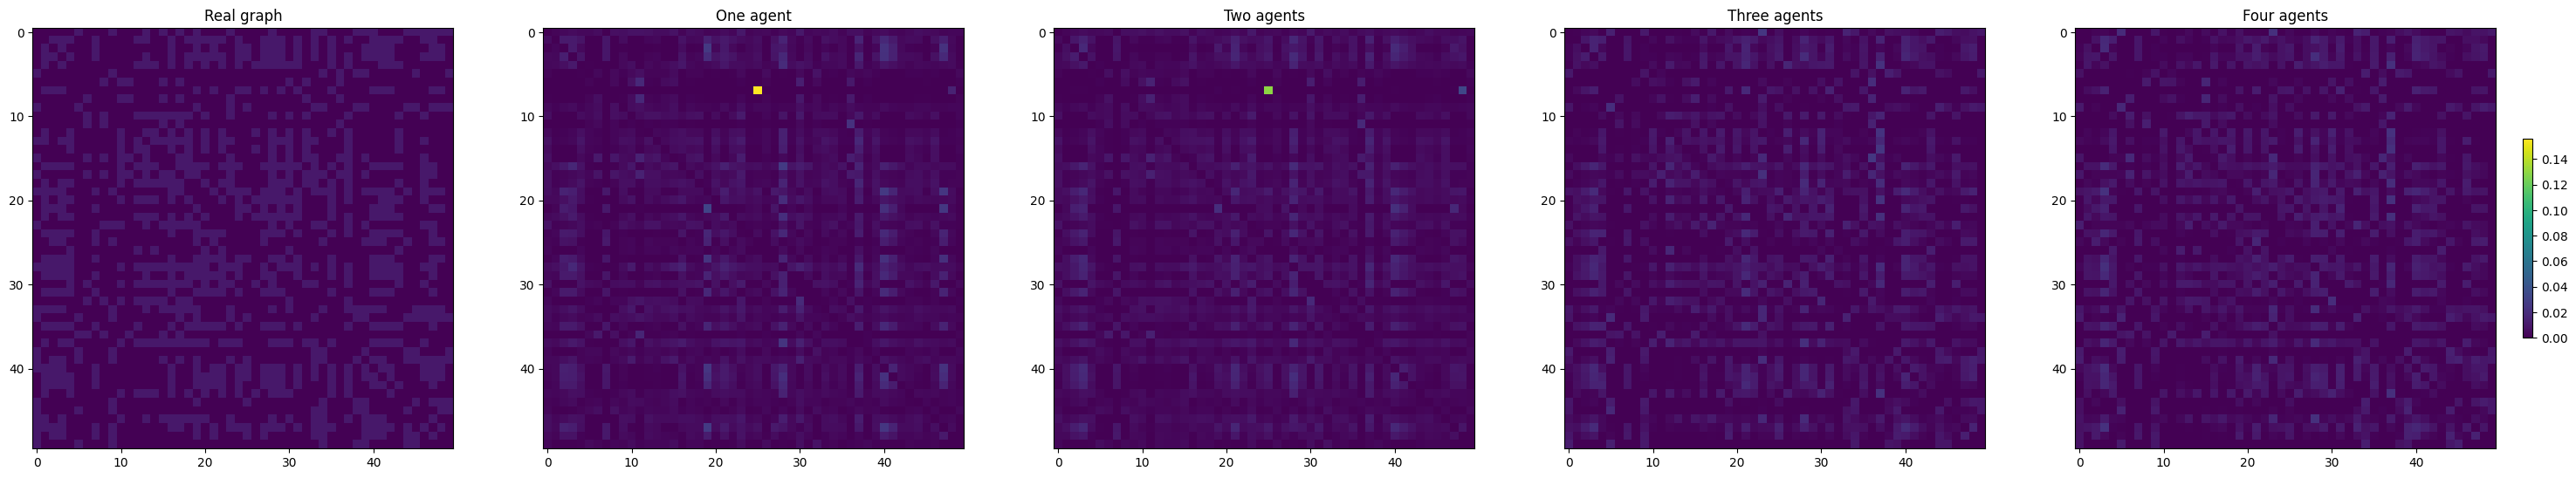

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import modules.plotGraph as plotGraph
import networkx as nx
from matplotlib.colors import Normalize

IMatrixNp= np.eye(50)

maxValue= 0
def load_npz_matrix(fileName, maxValue):
    npzfile = np.load(fileName)
    # Access the arrays in the NPZ file
    Aw = npzfile['A']
    PreA = npzfile['Apre']
    tempMax= np.max(PreA)
    if maxValue<tempMax:
        maxValue=tempMax
    return Aw, PreA, maxValue

PreAs= []
Aw= None
for i in range(4):
    fileName= f"results/AA/AAR_GEO_identical_13_{i+1}_0_140000.npz"
    Aw, PreA, maxValue= load_npz_matrix(fileName, maxValue)
    PreAs.append(PreA)

campThis= "viridis"

plt.figure(figsize=(30, 6))
# Set up a subplot with 1 row and 2 columns
plt.subplot(1, 5, 1)
plt.imshow(Aw, cmap= campThis, norm=Normalize(vmin=0, vmax= maxValue))
plt.title('Real graph')

colorbar =plt.colorbar(shrink=0.01)
colorbar.ax.set_axis_off()

plt.subplot(1, 5, 2)
plt.imshow(PreAs[0], cmap= campThis, norm=Normalize(vmin=0, vmax= maxValue))
plt.title('One agent')

colorbar =plt.colorbar(shrink=0.01)
colorbar.ax.set_axis_off()

plt.subplot(1, 5, 3)
plt.imshow(PreAs[1], cmap= campThis, norm=Normalize(vmin=0, vmax= maxValue))
plt.title('Two agents')

colorbar =plt.colorbar(shrink=0.01)
colorbar.ax.set_axis_off()

plt.subplot(1, 5, 4)
plt.imshow(PreAs[2], cmap= campThis, norm=Normalize(vmin=0, vmax= maxValue))
plt.title('Three agents')

colorbar =plt.colorbar(shrink=0.01)
colorbar.ax.set_axis_off()

plt.subplot(1, 5, 5)
plt.imshow(PreAs[3], cmap= campThis, norm=Normalize(vmin=0, vmax= maxValue))
plt.title('Four agents')

plt.colorbar(label='',  shrink=0.4)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

911


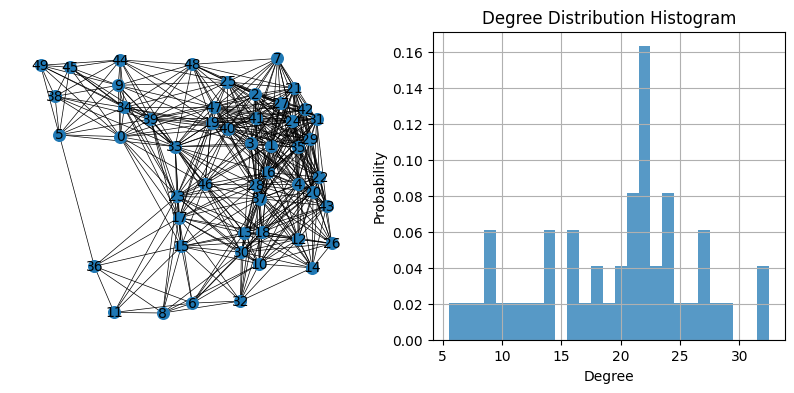

In [36]:
links= int((np.sum(Aw))/0.01)
print(links)

PreAsp= continious_to_sparcity(PreAs[3], links)
graphPreA = nx.from_numpy_matrix(PreAsp)

plotGraph.plot_spring_layout(graphPreA)

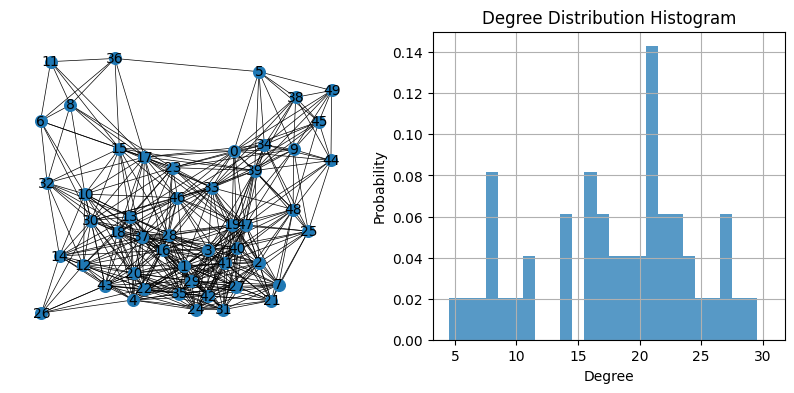

In [24]:
As= continious_to_sparcity(Aw, links)
graphA = nx.from_numpy_matrix(As)

plotGraph.plot_spring_layout(graphA)